In [109]:
# Import libraries
import pandas as pd
import numpy as np
import random
import os
from tqdm.notebook import tqdm

import geopandas as gpd
from shapely.geometry import Point
import folium

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
pd.options.display.float_format = '{:.5f}'.format
pd.options.display.max_rows = None
from sklearn.preprocessing import OrdinalEncoder


%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [110]:
# Set seed for reproducability
SEED = 2023
random.seed(SEED)
np.random.seed(SEED)

In [111]:
# Load files
train = pd.read_csv('Train.csv')
test = pd.read_csv( 'Test.csv')
samplesubmission = pd.read_csv( 'SampleSubmission.csv')

# Preview train dataset
train.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-23.73_28.77_2019_1,-23.73000,28.77000,2019,1,0.00017,0.71317,0.00010,0.22393,24.93944,...,5566.22202,54826.03262,4606.20999,19.11528,0.35378,24.95195,49.05395,-89.63803,17.98887,86.05170
1,ID_-23.73_28.77_2019_2,-23.73000,28.77000,2019,2,-0.00016,0.81291,-0.00014,0.08028,16.62416,...,3711.51137,68491.75334,3034.46166,12.21866,0.24499,4.70886,42.58668,-89.90431,22.77325,88.87567
2,ID_-23.73_28.77_2019_3,-23.73000,28.77000,2019,3,-0.00007,0.86031,-0.00006,0.16105,-13.23724,...,2136.38519,78967.73955,1433.48259,6.06274,0.24510,76.06063,34.73754,-83.59525,17.43730,91.72311
3,ID_-23.73_28.77_2019_4,-23.73000,28.77000,2019,4,0.00015,0.42228,0.00009,0.04650,-13.53465,...,3841.85302,64592.80677,2878.51292,6.38823,0.21090,75.91237,60.29449,-71.89673,11.97782,92.88387
4,ID_-23.73_28.77_2019_5,-23.73000,28.77000,2019,5,0.00002,1.00458,0.00003,0.21425,-13.47572,...,1295.68817,86804.02539,1094.66534,9.20625,0.26110,-13.34608,50.19449,-77.46208,24.37427,94.87833


<AxesSubplot:ylabel='NitrogenDioxide_NO2_column_number_density'>

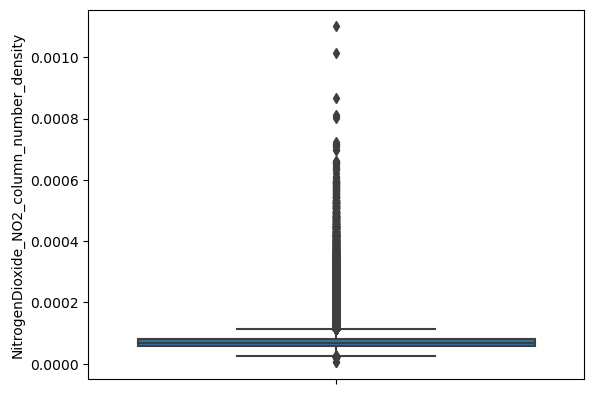

In [112]:
sns.boxplot(train,y='NitrogenDioxide_NO2_column_number_density')

In [113]:
display(train.shape)
display(train.isna().sum())

(74005, 76)

ID_LAT_LON_YEAR_WEEK                                            0
latitude                                                        0
longitude                                                       0
year                                                            0
week_no                                                         0
SulphurDioxide_SO2_column_number_density                     1930
SulphurDioxide_SO2_column_number_density_amf                 1930
SulphurDioxide_SO2_slant_column_number_density               1930
SulphurDioxide_cloud_fraction                                1930
SulphurDioxide_sensor_azimuth_angle                          1930
SulphurDioxide_sensor_zenith_angle                           1930
SulphurDioxide_solar_azimuth_angle                           1930
SulphurDioxide_solar_zenith_angle                            1930
SulphurDioxide_SO2_column_number_density_15km                1930
CarbonMonoxide_CO_column_number_density                       558
CarbonMono

In [114]:
# Preview test dataset
test.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle
0,ID_-23.53_27.47_2019_1,-23.53000,27.47000,2019,1,0.00008,0.45447,0.00003,0.11429,-80.28631,...,74897.05200,2180.26654,81287.07448,1562.03102,10.73412,0.28066,-31.23017,33.33797,-93.21726,23.35825
1,ID_-23.53_27.47_2019_2,-23.53000,27.47000,2019,2,0.00018,0.42317,0.00006,0.07510,-17.76569,...,84222.65352,982.61906,90307.65001,927.11122,5.25002,0.23893,66.49090,58.13779,-85.00147,13.41648
2,ID_-23.53_27.47_2019_3,-23.53000,27.47000,2019,3,0.00006,0.71309,0.00004,0.11421,16.72565,...,78922.49079,1582.96493,85383.15185,1006.77811,6.81937,0.25868,75.92319,41.33695,-83.26754,16.27300
3,ID_-23.53_27.47_2019_4,-23.53000,27.47000,2019,4,0.00048,0.43445,0.00017,0.13139,-22.47534,...,61135.91959,3935.41998,67490.03136,3428.42353,6.23363,0.28154,-11.02323,60.68987,-77.76372,22.79396
4,ID_-23.53_27.47_2019_5,-23.53000,27.47000,2019,5,0.00019,0.78304,0.00014,0.16114,4.75036,...,78494.24739,1647.53853,84478.74304,1122.53409,11.81025,0.28156,-13.29451,51.00713,-76.62065,23.19824


In [115]:
# Train statistical summary
train.describe(include = 'all')

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
count,74005,74005.00000,74005.00000,74005.00000,74005.00000,72075.00000,72075.00000,72075.00000,72075.00000,72075.00000,...,71281.00000,71281.00000,71281.00000,71281.00000,71281.00000,71281.00000,71281.00000,71281.00000,71281.00000,74005.00000
unique,74005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,ID_-23.73_28.77_2019_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,-27.82972,27.78274,2020.47805,26.15610,0.00026,0.51587,0.00009,0.10569,4.48763,...,3652.34972,74390.62446,2871.26282,15.82539,0.22544,-14.27712,49.56784,-50.51322,40.55896,7891.06097
std,NaN,2.76059,2.74667,1.11126,14.84384,0.00060,0.19677,0.00020,0.06955,52.24654,...,1807.38528,12859.06733,1645.82767,19.69665,0.06313,47.27732,12.09742,20.62391,12.20118,52571.60466
min,NaN,-33.93000,21.07000,2019.00000,1.00000,-0.00099,0.13374,-0.00083,0.00000,-110.02766,...,128.29979,14541.97799,10.30036,1.15114,0.00000,-125.29806,0.10088,-97.57091,10.90623,0.04806
25%,NaN,-29.63000,26.67000,2019.00000,13.00000,-0.00007,0.37174,-0.00003,0.05248,-18.17813,...,2260.91745,65920.34050,1602.61523,5.07185,0.18349,-31.95209,41.32913,-67.98772,29.78659,154.54720
50%,NaN,-28.13000,28.77000,2020.00000,26.00000,0.00015,0.48869,0.00007,0.09951,-10.98754,...,3437.87891,75994.80202,2563.92629,8.60904,0.22350,-13.73803,53.23303,-45.41392,40.11757,723.13586
75%,NaN,-25.73000,29.47000,2021.00000,39.00000,0.00044,0.62353,0.00019,0.15248,59.11999,...,4745.60794,84409.69113,3819.67139,17.47863,0.26772,3.79039,59.47813,-33.12496,51.44570,2773.02930


In [116]:
cat_cols = train.select_dtypes(include=['object']).columns
cat_cols

Index(['ID_LAT_LON_YEAR_WEEK'], dtype='object')

In [117]:
ID_col=train.ID_LAT_LON_YEAR_WEEK
train=train.drop(columns=["ID_LAT_LON_YEAR_WEEK"])

In [118]:
train.head()

,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,-23.73000,28.77000,2019,1,0.00017,0.71317,0.00010,0.22393,24.93944,56.89620,...,5566.22202,54826.03262,4606.20999,19.11528,0.35378,24.95195,49.05395,-89.63803,17.98887,86.05170
1,-23.73000,28.77000,2019,2,-0.00016,0.81291,-0.00014,0.08028,16.62416,31.13726,...,3711.51137,68491.75334,3034.46166,12.21866,0.24499,4.70886,42.58668,-89.90431,22.77325,88.87567
2,-23.73000,28.77000,2019,3,-0.00007,0.86031,-0.00006,0.16105,-13.23724,44.44106,...,2136.38519,78967.73955,1433.48259,6.06274,0.24510,76.06063,34.73754,-83.59525,17.43730,91.72311
3,-23.73000,28.77000,2019,4,0.00015,0.42228,0.00009,0.04650,-13.53465,61.25250,...,3841.85302,64592.80677,2878.51292,6.38823,0.21090,75.91237,60.29449,-71.89673,11.97782,92.88387
4,-23.73000,28.77000,2019,5,0.00002,1.00458,0.00003,0.21425,-13.47572,30.80077,...,1295.68817,86804.02539,1094.66534,9.20625,0.26110,-13.34608,50.19449,-77.46208,24.37427,94.87833


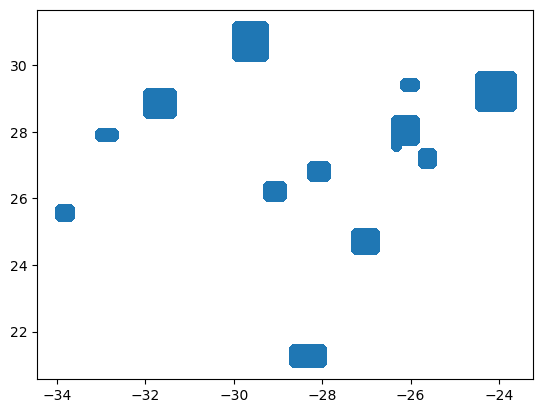

In [119]:
plt.scatter(train["latitude"],train["longitude"])

In [120]:
import math

# Define a function to transform latitude and longitude to x and y
def latlon_to_xy(lat, lon):
    # Convert to radians
    lat_rad = math.radians(lat)
    lon_rad = math.radians(lon)
    R = 6371  # Earth's radius in kilometers
    # Compute x and y coordinates using the Mercator projection
    x = R * lon_rad 
    y = R * math.log(math.tan(math.pi/4 + lat_rad/2)) 
    return x, y

# Transform latitude and longitude to x and y coordinates
train[['x', 'y']] = train.apply(lambda row: latlon_to_xy(row['latitude'], row['longitude']), axis=1, result_type='expand')




In [121]:
center_x = np.mean(train["x"].unique())
center_y = np.mean(train["y"].unique())

In [122]:
train['x'] -= center_x
train['y'] -= center_y

In [123]:
# polar coordinates
train['r'] = np.sqrt(train['x']**2 + train['y']**2)
train['theta'] = np.arctan2(train['y'], train['x'])

In [124]:
# clustering using DBSCAN
from sklearn.cluster import DBSCAN
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=40, min_samples=300)
cluster = dbscan.fit_predict(train[["x","y"]])

train["cluster"] = cluster

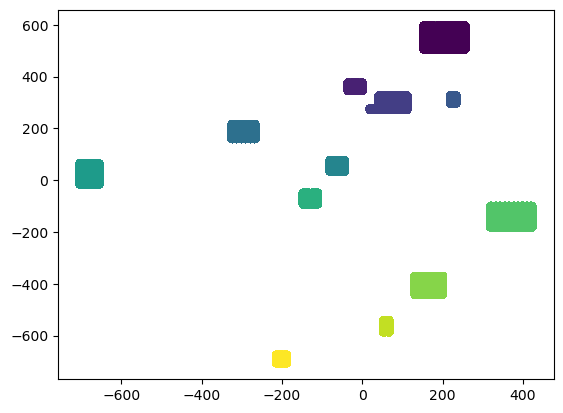

In [125]:
plt.scatter(train["x"],train["y"],c=cluster)

# Filling Naan Values

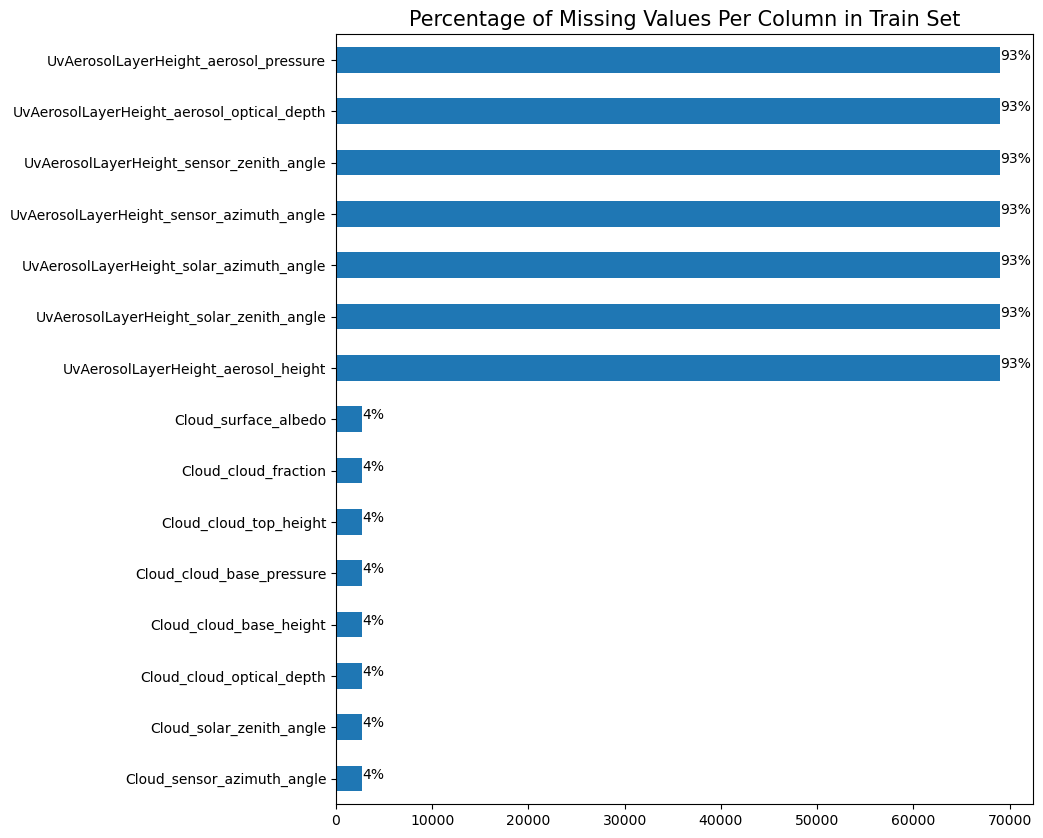

In [126]:
# Plot missing values in train set
ax = train.isna().sum().sort_values(ascending = False)[:15][::-1].plot(kind = 'barh', figsize = (9, 10))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

In [127]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
imputer.fit(train)
X_imputed0 = imputer.transform(train)
X=pd.DataFrame(X_imputed0,columns=train.columns)


In [128]:
ID_test=test.ID_LAT_LON_YEAR_WEEK
test.drop(columns='ID_LAT_LON_YEAR_WEEK',inplace=True)

In [129]:
imputer = SimpleImputer(strategy='mean')
imputer.fit(test)
X_imputed1 = imputer.transform(test)
test=pd.DataFrame(X_imputed1,columns=test.columns)

In [141]:
from sklearn.cluster import KMeans
for i in range(2,14):
    kmeans=KMeans(n_clusters=i)
    X[f"cluster_{i}"] = kmeans.fit_predict(X.iloc[:,:74])


# Deleting highly correlated colmuns

In [142]:
X.shape

(74005, 92)

In [143]:
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9) ]

In [144]:
to_drop

['SulphurDioxide_SO2_column_number_density_15km',
 'CarbonMonoxide_sensor_altitude',
 'CarbonMonoxide_solar_azimuth_angle',
 'CarbonMonoxide_solar_zenith_angle',
 'NitrogenDioxide_tropospheric_NO2_column_number_density',
 'NitrogenDioxide_NO2_slant_column_number_density',
 'NitrogenDioxide_sensor_altitude',
 'NitrogenDioxide_solar_azimuth_angle',
 'NitrogenDioxide_solar_zenith_angle',
 'Formaldehyde_HCHO_slant_column_number_density',
 'Formaldehyde_solar_zenith_angle',
 'Formaldehyde_solar_azimuth_angle',
 'UvAerosolIndex_absorbing_aerosol_index',
 'UvAerosolIndex_sensor_altitude',
 'UvAerosolIndex_solar_azimuth_angle',
 'UvAerosolIndex_solar_zenith_angle',
 'Ozone_O3_slant_column_number_density',
 'Ozone_sensor_azimuth_angle',
 'Ozone_sensor_zenith_angle',
 'Ozone_solar_azimuth_angle',
 'Ozone_solar_zenith_angle',
 'UvAerosolLayerHeight_aerosol_pressure',
 'Cloud_cloud_top_height',
 'Cloud_cloud_base_pressure',
 'Cloud_cloud_base_height',
 'Cloud_solar_azimuth_angle',
 'Cloud_solar_ze

In [88]:
#test.drop(columns=to_drop,inplace=True)
X.drop(columns=to_drop,inplace=True)

In [17]:
X.shape

(74005, 48)

# Target variable distribution

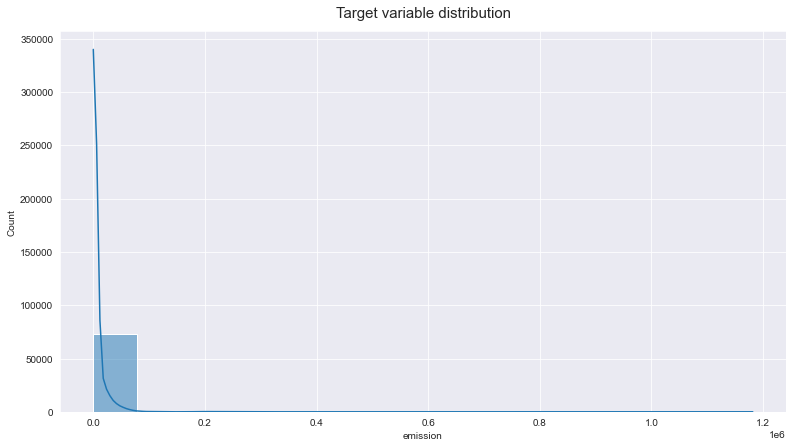

None

17.038027449698163

In [18]:
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.histplot(X.emission, kde = True, bins = 15)
plt.title('Target variable distribution', y = 1.02, fontsize = 15)
display(plt.show(), X.emission.skew())

In [149]:
max(X.emission)

1181701.2

In [20]:
X = X.drop(X[X['emission']>75000].index)

In [21]:
X.shape

(73398, 48)

# Feature Engineering

In [30]:
X['R']=np.sqrt(X['x']**2+(X['y']**2))
X['phi']=np.arctan(X['y'],X['x'])

In [23]:
test['R']=np.sqrt(test['latitude']**2+(test['longitude']**2))
test['phi']=np.arctan(test['latitude'],test['longitude'])

In [24]:
X.drop(columns=['latitude','longitude'],inplace=True)
test.drop(columns=['latitude','longitude'],inplace=True)

# Model

In [145]:
# Selecting the independent variables and the target variable
y = X.emission
X1=X.drop(columns='emission')

In [161]:

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size = 0.3, random_state = SEED)

# Instantiating the model
#clf = RandomForestRegressor(random_state = SEED, n_jobs=-1)
#clf.fit(X_train, y_train)

# Create the XGBoost model
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3,learning_rate = 0.03,
                max_depth =4, n_estimators = 1000,tree_method='gpu_hist')

# Train the model on the training data
xg_reg.fit(X_train, np.log(y_train+1), eval_set=[(X_train, y_train), (X_test, y_test)],verbose=10)

# Making predictions
y_pred = xg_reg.predict(X_test)

# Measuring the accuracy of the model
print(f'RMSE Score: {mean_squared_error(y_test, y_pred, squared=False)}') # 23432.342352754695

[0]	validation_0-rmse:54798.94531	validation_1-rmse:49124.00391
[10]	validation_0-rmse:54798.65234	validation_1-rmse:49123.69922
[20]	validation_0-rmse:54798.42578	validation_1-rmse:49123.46484
[30]	validation_0-rmse:54798.26562	validation_1-rmse:49123.30078
[40]	validation_0-rmse:54798.14453	validation_1-rmse:49123.17578
[50]	validation_0-rmse:54798.05859	validation_1-rmse:49123.08594
[60]	validation_0-rmse:54797.98828	validation_1-rmse:49123.01562
[70]	validation_0-rmse:54797.93359	validation_1-rmse:49122.96094
[80]	validation_0-rmse:54797.89453	validation_1-rmse:49122.91797
[90]	validation_0-rmse:54797.85938	validation_1-rmse:49122.88281
[100]	validation_0-rmse:54797.83594	validation_1-rmse:49122.85547
[110]	validation_0-rmse:54797.81641	validation_1-rmse:49122.83594
[120]	validation_0-rmse:54797.80469	validation_1-rmse:49122.82422
[130]	validation_0-rmse:54797.78906	validation_1-rmse:49122.80859
[140]	validation_0-rmse:54797.78125	validation_1-rmse:49122.80078
[150]	validation_0-rm

In [163]:
print(f'RMSE Score: {mean_squared_error(y_test, np.exp(y_pred)-1, squared=False)}') # 23432.342352754695

RMSE Score: 32768.55489787764


# Feature Selection

In [27]:
importances = xg_reg.feature_importances_
feature_names = X.columns

for idx, importance in enumerate(importances.argsort()[::-1]):
    print("{}. Feature: {}, Importance score: {:.2f}".format(
        idx+1, feature_names[importance], importances[importance]))
    if (importances[importance]==0):
        X.drop(columns=feature_names[importance],inplace=True)
        test.drop(columns=feature_names[importance],inplace=True)

1. Feature: NitrogenDioxide_NO2_column_number_density, Importance score: 0.27
2. Feature: R, Importance score: 0.22
3. Feature: phi, Importance score: 0.14
4. Feature: Cloud_cloud_fraction, Importance score: 0.05
5. Feature: SulphurDioxide_SO2_column_number_density_amf, Importance score: 0.03
6. Feature: Cloud_surface_albedo, Importance score: 0.03
7. Feature: NitrogenDioxide_cloud_fraction, Importance score: 0.02
8. Feature: year, Importance score: 0.02
9. Feature: NitrogenDioxide_absorbing_aerosol_index, Importance score: 0.02
10. Feature: Cloud_cloud_top_pressure, Importance score: 0.02
11. Feature: Formaldehyde_tropospheric_HCHO_column_number_density_amf, Importance score: 0.01
12. Feature: Formaldehyde_tropospheric_HCHO_column_number_density, Importance score: 0.01
13. Feature: CarbonMonoxide_sensor_azimuth_angle, Importance score: 0.01
14. Feature: Cloud_cloud_optical_depth, Importance score: 0.01
15. Feature: Formaldehyde_cloud_fraction, Importance score: 0.01
16. Feature: Carbo

In [30]:
# Make prediction on the test set

predictions = xg_reg.predict(test)
# # Create a submission file
sub_file = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': ID_test, 'emission': predictions})
sub_file.head()

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-23.53_27.47_2019_1,1042.96008
1,ID_-23.53_27.47_2019_2,1779.22021
2,ID_-23.53_27.47_2019_3,1690.63904
3,ID_-23.53_27.47_2019_4,2745.92236
4,ID_-23.53_27.47_2019_5,2401.21460


In [31]:
# Create file
sub_file.to_csv('BaselineSubmission.csv', index = False)